In [1]:
import os
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
import pandapower.networks as pn
from torch_geometric.data import Data


# 设置随机种子，保证你和我的结果一致
np.random.seed(2025)

# 绘图风格设置
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'

# 检查路径是否存在，不存在则创建
save_dir = "../data/raw"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建目录: {save_dir}")
else:
    print(f"数据保存目录: {save_dir}")

数据保存目录: ../data/raw


In [2]:
def get_ieee33_with_pv():
    """
    加载 IEEE 33 节点系统，并在末端节点添加光伏发电机 (Static Generators)
    """
    net = pn.case33bw()
    
    # 定义光伏接入点：通常在馈线末端，电压波动最大
    # 注意：Pandapower 的 bus 索引是从 0 开始的
    # 节点 18 (Bus 17), 节点 22 (Bus 21), 节点 25 (Bus 24), 节点 33 (Bus 32)
    pv_buses = [17, 21, 24, 32] 
    
    # 为每个接入点添加光伏 (sgen)
    # 初始设为 0，后面我们在循环中动态修改
    for bus in pv_buses:
        pp.create_sgen(net, bus, p_mw=0, q_mvar=0, name=f"PV_at_Bus_{bus}")
        
    return net, pv_buses

# 测试一下模型是否加载成功
test_net, test_pv_buses = get_ieee33_with_pv()
print(f"IEEE 33 系统加载成功。")
print(f"光伏接入 Bus 索引: {test_pv_buses}")
print(f"系统总负荷: {test_net.load.p_mw.sum():.2f} MW")

IEEE 33 系统加载成功。
光伏接入 Bus 索引: [17, 21, 24, 32]
系统总负荷: 3.71 MW


In [ ]:
from joblib import Parallel, delayed
import multiprocessing

# 1. 把“生成单次样本”的逻辑封装成一个函数
def generate_batch(batch_size, seed_offset):
    # 每个进程内部重新设置随机种子，防止生成重复数据
    np.random.seed(None) 
    
    # 在进程内部重新加载网格（避免跨进程传递大对象）
    net, _ = get_ieee33_with_pv() 
    n_bus = len(net.bus)
    
    base_load_p = net.load.p_mw.values.copy()
    base_load_q = net.load.q_mvar.values.copy()
    pv_capacity_base = 3.0
    
    local_V, local_Ang, local_P, local_Q = [], [], [], []
    
    for i in range(batch_size):
        # --- 这里的逻辑和你之前的一模一样 ---
        mode = np.random.choice(['heavy_load', 'high_gen', 'normal', 'random_mix'], p=[0.3, 0.3, 0.2, 0.2])
        
        if mode == 'heavy_load':
            load_scale = np.random.uniform(1.1, 1.8)
            pv_output_scaling = np.random.uniform(0.0, 0.2)
        elif mode == 'high_gen':
            load_scale = np.random.uniform(0.1, 0.5)
            pv_output_scaling = np.random.uniform(0.8, 1.1)
        elif mode == 'normal':
            load_scale = np.random.uniform(0.5, 1.2)
            pv_output_scaling = np.random.uniform(0.2, 0.8)
        else:
            load_scale = np.random.uniform(0.1, 1.8)
            pv_output_scaling = np.random.uniform(0.0, 1.1)
            
        node_noise = np.random.normal(1.0, 0.05, len(net.load))
        net.load.p_mw = base_load_p * load_scale * node_noise
        net.load.q_mvar = base_load_q * load_scale * node_noise
        
        pv_noise = np.random.uniform(0.95, 1.05, len(net.sgen))
        current_pv_mw = pv_capacity_base * pv_output_scaling * pv_noise
        net.sgen.p_mw = current_pv_mw 
        
        try:
            pp.runpp(net, algorithm='nr', init="flat")
        except:
            continue
            
        voltage_res = net.res_bus.vm_pu.values.copy()
        angle_res = net.res_bus.va_degree.values.copy()
        
        # 计算 P_net (简易版)
        p_net = np.zeros(n_bus)
        q_net = np.zeros(n_bus)
        # 注意：这里为了速度，假设索引对齐（Pandapower通常是对齐的，但也可用 map）
        p_net[net.load.bus] -= net.load.p_mw.values
        q_net[net.load.bus] -= net.load.q_mvar.values
        p_net[net.sgen.bus] += net.sgen.p_mw.values
        
        local_V.append(voltage_res)
        local_Ang.append(angle_res)
        local_P.append(p_net)
        local_Q.append(q_net)
        
    return local_V, local_Ang, local_P, local_Q

# 2. 主函数：并行调度
def run_fast_simulation(total_samples=5000, n_jobs=-1):
    print(f"🚀 启动多核加速 (CPU核心数: {multiprocessing.cpu_count()})...")
    
    # 分割任务：比如 5000 个样本，分成 50 个包，每个包 100 个
    batch_size = 100
    n_batches = total_samples // batch_size
    
    # 并行执行
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(generate_batch)(batch_size, i) for i in range(n_batches)
    )
    
    # 合并结果
    print("正在合并数据...")
    all_V, all_Ang, all_P, all_Q = [], [], [], []
    for res in results:
        v, ang, p, q = res
        all_V.extend(v)
        all_Ang.extend(ang)
        all_P.extend(p)
        all_Q.extend(q)
    print("完成")
    return np.array(all_V), np.array(all_Ang), np.array(all_P), np.array(all_Q)

# 执行！
# n_jobs=-1 表示用满所有 CPU 核心
V_data, Ang_data, P_data, Q_data = run_fast_simulation(5000, n_jobs=-1)

🚀 启动多核加速 (CPU核心数: 24)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    8.3s remaining:   38.4s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    8.6s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    8.8s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    9.5s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    9.8s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    9.9s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   10.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.5s finished


正在合并数据...


In [6]:
# 保存为 .npy 格式
np.save(os.path.join(save_dir, "voltage_magnitude.npy"), V_data)
np.save(os.path.join(save_dir, "voltage_angle.npy"), Ang_data)
np.save(os.path.join(save_dir, "active_power.npy"), P_data)
np.save(os.path.join(save_dir, "reactive_power.npy"), Q_data)

print("数据保存完毕。")
print(f"V Shape: {V_data.shape}")
print(f"Ang Shape: {Ang_data.shape}")
print(f"P Shape: {P_data.shape}")
print(f"Q Shape: {Q_data.shape}")


数据保存完毕。
V Shape: (5000, 33)
Ang Shape: (5000, 33)
P Shape: (5000, 33)
Q Shape: (5000, 33)


      DATA QUALITY CHECK REPORT
[1] 电压幅值统计:
    Min: 0.8320 (期望 < 0.95)
    Max: 1.2185 (期望 > 1.05)
    Mean: 1.0071
    低电压样本点占比 (<0.95): 21.09%
    过电压样本点占比 (>1.05): 24.30%

[2] 电压相角统计 (Degree):
    Range: [-0.99, 11.57]
    ✅ 通过：相角具有一定的分布范围。


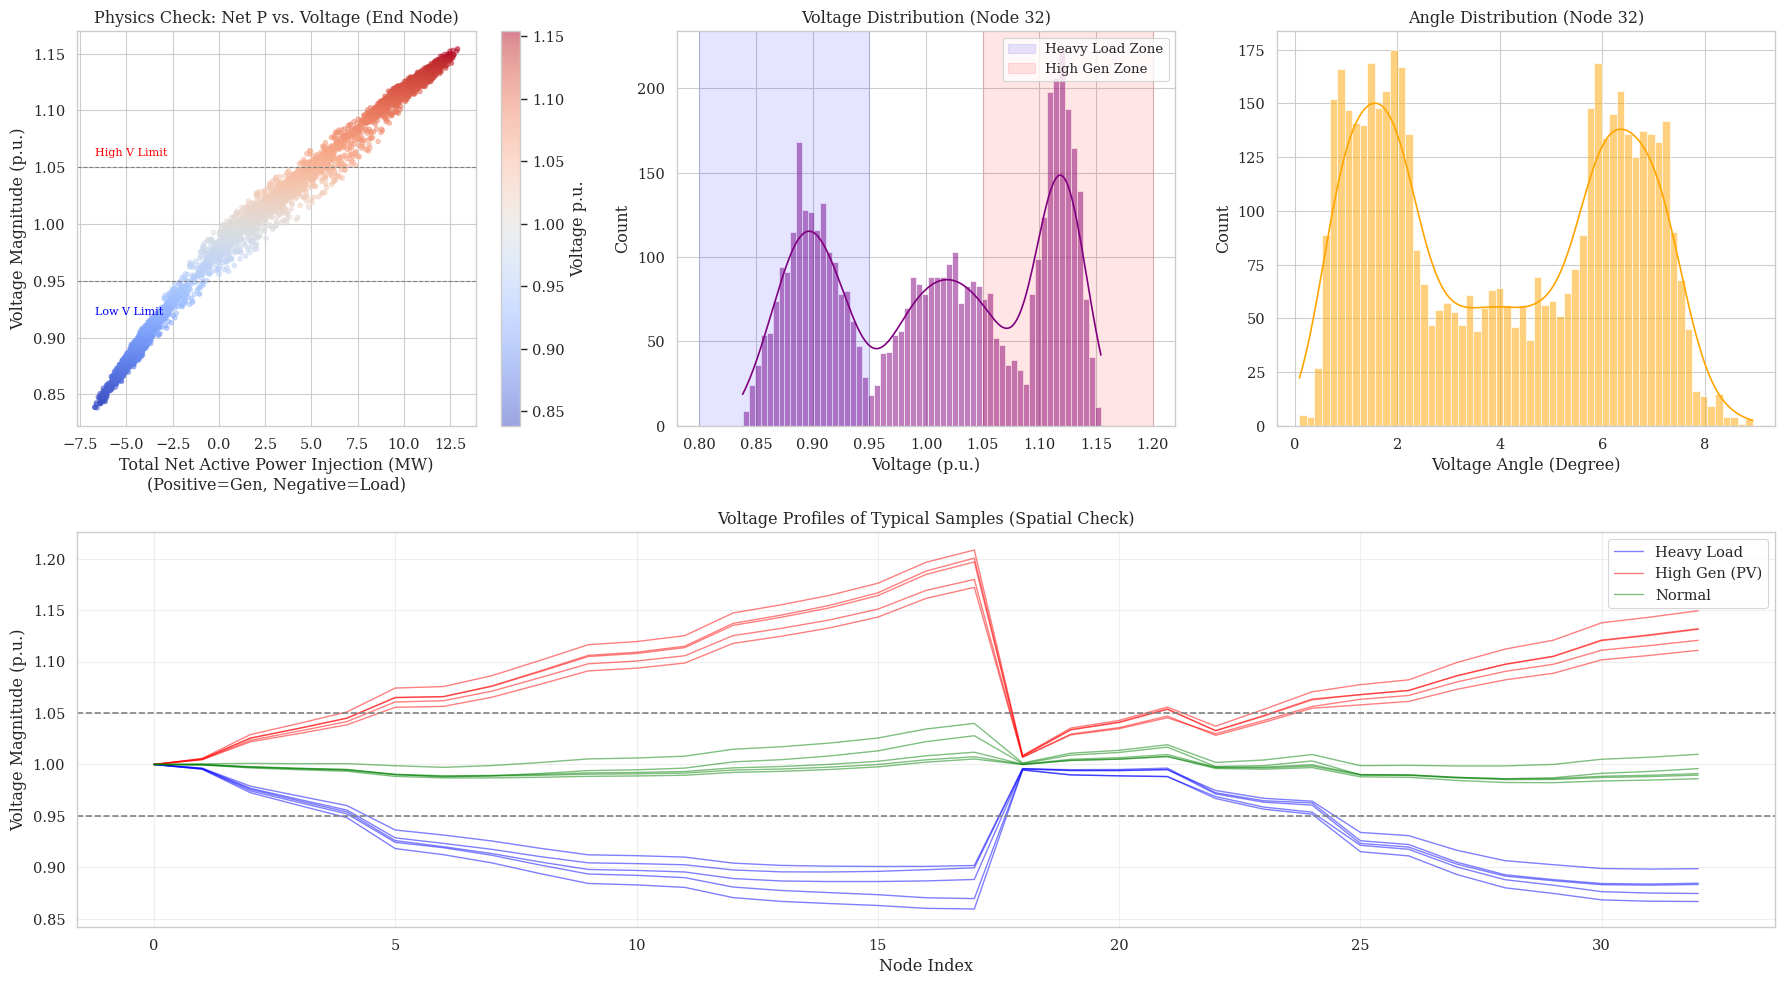

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def analyze_data_quality(V, Ang, P, Q):
    """
    全方位检测电力系统仿真数据质量
    :param V: [n_samples, n_nodes] 电压幅值
    :param Ang: [n_samples, n_nodes] 电压相角
    :param P: [n_samples, n_nodes] 有功注入
    :param Q: [n_samples, n_nodes] 无功注入
    """
    n_samples, n_nodes = V.shape
    target_node = n_nodes - 1  # 选择末端节点 (Node 32)
    
    print(f"========================================")
    print(f"      DATA QUALITY CHECK REPORT")
    print(f"========================================")
    
    # --- 1. 基础统计量检查 ---
    v_flat = V.flatten()
    print(f"[1] 电压幅值统计:")
    print(f"    Min: {v_flat.min():.4f} (期望 < 0.95)")
    print(f"    Max: {v_flat.max():.4f} (期望 > 1.05)")
    print(f"    Mean: {v_flat.mean():.4f}")
    
    # 统计越限比例
    n_low = np.sum(V < 0.95)
    n_high = np.sum(V > 1.05)
    print(f"    低电压样本点占比 (<0.95): {n_low / (n_samples*n_nodes) * 100:.2f}%")
    print(f"    过电压样本点占比 (>1.05): {n_high / (n_samples*n_nodes) * 100:.2f}%")
    
    # --- 2. 相角统计检查 ---
    ang_flat = Ang.flatten()
    print(f"\n[2] 电压相角统计 (Degree):")
    print(f"    Range: [{ang_flat.min():.2f}, {ang_flat.max():.2f}]")
    if ang_flat.max() - ang_flat.min() < 1.0:
        print("    ⚠️ 警告：相角变化极小，可能未正确提取或物理模型过于简单！")
    else:
        print("    ✅ 通过：相角具有一定的分布范围。")

    # --- 3. 物理规律一致性检查 (P-V 关系) ---
    # 计算每个样本的总注入功率 (Net P) 和 末端电压 (V_end)
    # Net P > 0 说明光伏多，Net P < 0 说明负荷多
    total_p_injection = np.sum(P, axis=1)
    v_end = V[:, target_node]
    
    # --- 可视化 ---
    fig = plt.figure(figsize=(18, 10))
    plt.subplots_adjust(hspace=0.3)

    # 图 1: P-V 散点图 (核心物理检查)
    # 这张图应该能清晰地看到三个聚类（Cluster）
    ax1 = plt.subplot(2, 3, 1)
    sc = ax1.scatter(total_p_injection, v_end, c=v_end, cmap='coolwarm', alpha=0.5, s=10)
    ax1.set_title("Physics Check: Net P vs. Voltage (End Node)")
    ax1.set_xlabel("Total Net Active Power Injection (MW)\n(Positive=Gen, Negative=Load)")
    ax1.set_ylabel("Voltage Magnitude (p.u.)")
    ax1.axhline(0.95, color='gray', linestyle='--', linewidth=0.8)
    ax1.axhline(1.05, color='gray', linestyle='--', linewidth=0.8)
    ax1.text(total_p_injection.min(), 0.92, "Low V Limit", color='blue', fontsize=8)
    ax1.text(total_p_injection.min(), 1.06, "High V Limit", color='red', fontsize=8)
    plt.colorbar(sc, ax=ax1, label='Voltage p.u.')

    # 图 2: 电压双峰/多峰分布直方图
    ax2 = plt.subplot(2, 3, 2)
    sns.histplot(v_end, kde=True, bins=60, color='purple', ax=ax2)
    ax2.set_title(f"Voltage Distribution (Node {target_node})")
    ax2.set_xlabel("Voltage (p.u.)")
    # 标记理想的分布区域
    ax2.axvspan(0.8, 0.95, color='blue', alpha=0.1, label='Heavy Load Zone')
    ax2.axvspan(1.05, 1.2, color='red', alpha=0.1, label='High Gen Zone')
    ax2.legend(loc='upper right', fontsize='small')

    # 图 3: 相角分布直方图
    ax3 = plt.subplot(2, 3, 3)
    sns.histplot(Ang[:, target_node], kde=True, bins=60, color='orange', ax=ax3)
    ax3.set_title(f"Angle Distribution (Node {target_node})")
    ax3.set_xlabel("Voltage Angle (Degree)")

    # 图 4: 典型样本的电压剖面 (Spaghetti Plot)
    # 从高中低电压中各选几个样本画线
    ax4 = plt.subplot(2, 1, 2)
    
    # 筛选索引
    idx_low = np.where(v_end < 0.95)[0][:5]   # 取5个低电压样本
    idx_high = np.where(v_end > 1.05)[0][:5]  # 取5个高电压样本
    idx_norm = np.where((v_end >= 0.98) & (v_end <= 1.02))[0][:5] # 取5个正常样本
    
    nodes = np.arange(n_nodes)
    
    for i in idx_low:
        ax4.plot(nodes, V[i, :], color='blue', alpha=0.5, linewidth=1, label='Heavy Load' if i==idx_low[0] else "")
    for i in idx_high:
        ax4.plot(nodes, V[i, :], color='red', alpha=0.5, linewidth=1, label='High Gen (PV)' if i==idx_high[0] else "")
    for i in idx_norm:
        ax4.plot(nodes, V[i, :], color='green', alpha=0.5, linewidth=1, label='Normal' if i==idx_norm[0] else "")
        
    ax4.set_title("Voltage Profiles of Typical Samples (Spatial Check)")
    ax4.set_xlabel("Node Index")
    ax4.set_ylabel("Voltage Magnitude (p.u.)")
    ax4.axhline(0.95, color='gray', linestyle='--')
    ax4.axhline(1.05, color='gray', linestyle='--')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- 执行检测 ---
# 假设 V_data, Ang_data, P_data, Q_data 已经由你上面的函数生成好了
analyze_data_quality(V_data, Ang_data, P_data, Q_data)

In [ ]:
def get_ieee33_topology():
    net = pn.case33bw()
    
    # 1. Edge Index (连接关系)
    # Pandapower 的 line 表格存储了 from_bus 和 to_bus
    from_nodes = net.line.from_bus.values
    to_nodes = net.line.to_bus.values
    
    # 构建双向图 (Undirected Graph)
    # GNN 中 A-B 通常表示为 A->B 和 B->A 两条边
    src = np.concatenate([from_nodes, to_nodes])
    dst = np.concatenate([to_nodes, from_nodes])
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    
    # 2. Edge Attributes (线路阻抗 R, X)
    # 必须转换为 p.u. 值 (假设基准功率 10MVA, 基准电压 12.66kV)
     # 这里为了简化，我们直接取 pandapower 计算好的 p.u. 值 (如果有)
    u_base = 12.66 # kV
    s_base = 10.0  # MVA (Pandapower 默认 baseMVA 通常是 100 或 10，需确认 net.sn_mva)
    z_base = (u_base ** 2) / s_base 
    
    r_ohm = net.line.r_ohm_per_km.values * net.line.length_km.values
    x_ohm = net.line.x_ohm_per_km.values * net.line.length_km.values
    
    r_pu = r_ohm / z_base
    x_pu = x_ohm / z_base
    
    # 拼接双向
    r_all = np.concatenate([r_pu, r_pu])
    x_all = np.concatenate([x_pu, x_pu])
    
    # [关键修正] 保存两份属性
    # 1. 真实物理值 (用于 PINN Loss)
    edge_attr_real = np.stack([r_all, x_all], axis=1)
    
    # 2. 归一化值 (用于 GAT 输入)
    edge_attr_norm = (edge_attr_real - edge_attr_real.mean(axis=0)) / (edge_attr_real.std(axis=0) + 1e-6)
    
    return (torch.tensor(edge_index, dtype=torch.long), 
            torch.tensor(edge_attr_norm, dtype=torch.float32),
            torch.tensor(edge_attr_real, dtype=torch.float32))

edge_index, edge_attr_norm, edge_attr_real = get_ieee33_topology()
print(f"拓扑构建完成: Edge Index {edge_index.shape}, Edge Attr {edge_attr_norm.shape}, Real Attr {edge_attr_real.shape}")

C:\Users\10856\AppData\Local\Temp\ipykernel_24304\2313981401.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(edge_index, dtype=torch.long),


拓扑构建完成: Edge Index torch.Size([2, 74]), Edge Attr torch.Size([74, 2]), Real Attr torch.Size([74, 2])


In [ ]:
def process_data():
    # 1. 加载我们在 Step 01 生成的“黄金数据”
    raw_dir = "../data/raw"
    V = np.load(os.path.join(raw_dir, "voltage_magnitude.npy")) # [5000, 33]
    P = np.load(os.path.join(raw_dir, "active_power.npy"))      # [5000, 33]
    Q = np.load(os.path.join(raw_dir, "reactive_power.npy"))    # [5000, 33]
    
    print(f"原始数据加载: V shape={V.shape}")
    
    # 2. 计算全局统计量 (用于归一化和反归一化)
    # 我们需要保存这些 stats，以便在后续画图时把 [-1, 1] 还原回 [0.85, 1.07]
    stats = {
        'v_min': V.min(), 'v_max': V.max(),
        'p_mean': P.mean(), 'p_std': P.std(),
        'q_mean': Q.mean(), 'q_std': Q.std()
    }
    
    data_list = []
    
    print("开始封装图数据...")
    for i in tqdm(range(len(V))):
        # --- 输入特征 X (Condition) ---
        # 即使是 Diffusion，我们也需要输入条件 (P, Q)
        # Z-Score 标准化 P 和 Q
        p_norm = (P[i] - stats['p_mean']) / (stats['p_std'] + 1e-6)
        q_norm = (Q[i] - stats['q_mean']) / (stats['q_std'] + 1e-6)
        x = torch.tensor(np.stack([p_norm, q_norm], axis=1), dtype=torch.float32) # [33, 2]
        
        # --- 预测目标 Y (State) ---
        # Diffusion 的目标变量通常归一化到 [-1, 1]
        v_norm = 2 * (V[i] - stats['v_min']) / (stats['v_max'] - stats['v_min']) - 1
        y = torch.tensor(v_norm, dtype=torch.float32).view(-1, 1) # [33, 1]
        
        # 构建 Data 对象
        data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)
        data_list.append(data)
        
    # 3. 保存
    torch.save(data_list, os.path.join(processed_dir, "ieee33_graph_data.pt"))
    torch.save(stats, os.path.join(processed_dir, "data_stats.pt"))
    
    return stats

# 执行处理
# 确保输出目录存在
processed_dir = "../data/processed"
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)
stats = process_data()

print("\n=== 数据处理报告 ===")
print(f"V范围 (原始): [{stats['v_min']:.4f}, {stats['v_max']:.4f}]")
print(f"P均值/方差: {stats['p_mean']:.4f} / {stats['p_std']:.4f}")
print("处理完成。")

原始数据加载: V shape=(5000, 33)
开始封装图数据...


100%|██████████| 5000/5000 [00:00<00:00, 42000.24it/s]



=== 数据处理报告 ===
V范围 (原始): [0.8459, 1.1113]
P均值/方差: -0.0359 / 0.2604
处理完成。


In [ ]:
data_list = torch.load("../data/processed/ieee33_graph_data.pt", weights_only=False)
stats = torch.load("../data/processed/data_stats.pt", weights_only=False)


print(f"Type: {type(data_list)}")
print(f"Length: {len(data_list)}")
print(f"Sample 0: {data_list[0]}")

Type: <class 'list'>
Length: 5000
Sample 0: Data(x=[33, 2], edge_index=[2, 74], edge_attr=[74, 2], y=[33, 1])


In [ ]:
stats = torch.load("../data/processed/data_stats.pt", weights_only=False)
print(stats)

{'v_min': np.float64(0.8459156974847377), 'v_max': np.float64(1.1112722422243233), 'p_mean': np.float64(-0.03588815013927076), 'p_std': np.float64(0.2603615456857231), 'q_mean': np.float64(-0.05657861198593047), 'q_std': np.float64(0.10562188460499562)}
